# MLP+HOG

- Optimise HOG feature extraction with Optuna
- Train model on optimised features
- Optimise hyperparameters with Optuna
- Find the final validation and test accuracy



In [1]:
#imports
import json
import joblib
import torch
import random
import optuna
import numpy as np
from pathlib import Path
import cv2
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
#path setup and data loading
projectRoot = Path().resolve().parent
outputRoot = projectRoot / "ModifiedDataset"

trainImagePath = outputRoot / "train" / "images"
trainLabelPath = outputRoot / "train" / "labels"
augImagePath = outputRoot / "AugmentedData" / "images"
augLabelPath = outputRoot / "AugmentedData" / "labels"
testImagePath = outputRoot / "test" / "images"
testLabelPath = outputRoot / "test" / "labels"

with open(outputRoot / "kfold_splits.json", "r") as f:
    kfold_splits = json.load(f)

def load_dataset(image_dir, label_dir):
    paths, labels = [], []
    for fname in sorted(os.listdir(image_dir)):
        if fname.endswith('.jpeg'):
            paths.append(str(image_dir / fname))
            with open(label_dir / fname.replace('.jpeg', '.txt')) as f:
                labels.append(int(f.read().strip()))
    return paths, np.array(labels)

train_image_paths, train_labels = load_dataset(trainImagePath, trainLabelPath)
aug_image_paths, aug_labels = load_dataset(augImagePath, augLabelPath)
test_image_paths, test_labels = load_dataset(testImagePath, testLabelPath)

all_paths = train_image_paths + aug_image_paths
all_labels = np.concatenate([train_labels, aug_labels])


In [3]:
#HOG feature extraction
def extract_hog_features(paths, orientations, ppc, cpb):
    hog = cv2.HOGDescriptor(
        _winSize=(64, 64),
        _blockSize=(ppc[0]*cpb[0], ppc[1]*cpb[1]),
        _blockStride=ppc,
        _cellSize=ppc,
        _nbins=orientations
    )
    features = []
    for path in paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64))
        feat = hog.compute(img)
        features.append(feat.flatten())
    return np.array(features)


In [4]:
#MLP forward pass
def forward_mlp(x, weights):
    x = F.linear(x, weights['w1'], weights['b1'])
    x = F.relu(x)
    x = F.dropout(x, p=weights['dropout'], training=weights['train'])
    x = F.linear(x, weights['w2'], weights['b2'])
    return x


In [5]:
def train_mlp(X_train, y_train, X_val, y_val, input_dim, hidden_dim, lr, dropout):
    w1 = nn.Parameter(torch.empty(hidden_dim, input_dim, device=device))
    nn.init.normal_(w1, mean=0.0, std=0.01)

    b1 = nn.Parameter(torch.zeros(hidden_dim, device=device))

    w2 = nn.Parameter(torch.empty(3, hidden_dim, device=device))
    nn.init.normal_(w2, mean=0.0, std=0.01)

    b2 = nn.Parameter(torch.zeros(3, device=device))

    model = {
        'w1': w1,
        'b1': b1,
        'w2': w2,
        'b2': b2,
        'dropout': dropout,
        'train': True
    }

    optimizer = optim.Adam([w1, b1, w2, b2], lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train)), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val)), batch_size=64)

    best_acc = 0
    best_weights = None
    patience = 0

    for epoch in range(20):
        model['train'] = True
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = forward_mlp(xb, model)
            loss = criterion(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model['train'] = False
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = forward_mlp(xb, model).argmax(1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)

        acc = correct / total
        if acc > best_acc:
            best_acc = acc
            best_weights = {k: v.clone().detach() if isinstance(v, torch.Tensor) else v for k, v in model.items()}
            patience = 0
        else:
            patience += 1
        if patience >= 5:
            break

    return best_weights, best_acc


In [6]:
#Optuna objective
def objective(trial):
    orientations = trial.suggest_categorical("orientations", [6, 8, 9, 10, 12])
    ppc = (
        trial.suggest_categorical("ppc_x", [4, 6, 8, 10, 12]),
        trial.suggest_categorical("ppc_y", [4, 6, 8, 10, 12])
    )
    cpb = (
        trial.suggest_categorical("cpb_x", [2, 3, 4]),
        trial.suggest_categorical("cpb_y", [2, 3, 4])
    )
    hidden_dim = trial.suggest_int("hidden_dim", 64, 512, step=32)
    lr = trial.suggest_float("lr", 1e-5, 5e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.6)


    try:
        features = extract_hog_features(all_paths, orientations, ppc, cpb)
    except:
        raise optuna.exceptions.TrialPruned()

    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    fold_accuracies = []
    for fold_num, fold in enumerate(kfold_splits):
        train_idx = kfold_splits[fold]['train']
        val_idx = kfold_splits[fold]['val']

        X_train, y_train = features[train_idx], all_labels[train_idx]
        X_val, y_val = features[val_idx], all_labels[val_idx]

        model, acc = train_mlp(X_train, y_train, X_val, y_val, features.shape[1], hidden_dim, lr, dropout)
        fold_accuracies.append(acc)

        trial.report(acc, step=fold_num)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return np.mean(fold_accuracies)


In [7]:
#run Optuna search
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42), pruner=MedianPruner())
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("\nBest Parameters:")
print(best_params)


[I 2025-04-24 00:47:54,567] A new study created in memory with name: no-name-b13ff378-0860-4106-bb67-34fb8bf1fc51
[I 2025-04-24 00:47:54,576] Trial 0 pruned. 
[I 2025-04-24 00:47:54,583] Trial 1 pruned. 
[I 2025-04-24 00:47:54,589] Trial 2 pruned. 
[I 2025-04-24 00:47:54,594] Trial 3 pruned. 
[I 2025-04-24 00:47:54,599] Trial 4 pruned. 
[I 2025-04-24 00:47:54,603] Trial 5 pruned. 
[I 2025-04-24 00:47:54,608] Trial 6 pruned. 
[I 2025-04-24 00:47:54,613] Trial 7 pruned. 
[I 2025-04-24 00:47:54,618] Trial 8 pruned. 
[I 2025-04-24 00:48:17,825] Trial 9 finished with value: 0.8274432979244422 and parameters: {'orientations': 10, 'ppc_x': 4, 'ppc_y': 4, 'cpb_x': 3, 'cpb_y': 3, 'hidden_dim': 64, 'lr': 0.0024410836460802636, 'dropout': 0.18855533970352448}. Best is trial 9 with value: 0.8274432979244422.
[I 2025-04-24 00:48:36,582] Trial 10 finished with value: 0.8607059260635334 and parameters: {'orientations': 10, 'ppc_x': 4, 'ppc_y': 8, 'cpb_x': 3, 'cpb_y': 2, 'hidden_dim': 64, 'lr': 0.0011


Best Parameters:
{'orientations': 6, 'ppc_x': 8, 'ppc_y': 8, 'cpb_x': 2, 'cpb_y': 4, 'hidden_dim': 448, 'lr': 0.0003806218942811847, 'dropout': 0.4143289683912376}


In [8]:
# final feature extraction and save
hog_train = extract_hog_features(all_paths, best_params['orientations'], (best_params['ppc_x'], best_params['ppc_y']), (best_params['cpb_x'], best_params['cpb_y']))
hog_test = extract_hog_features(test_image_paths, best_params['orientations'], (best_params['ppc_x'], best_params['ppc_y']), (best_params['cpb_x'], best_params['cpb_y']))

scaler = StandardScaler()
hog_train = scaler.fit_transform(hog_train)
hog_test = scaler.transform(hog_test)

model_save_dir = projectRoot / "models"
model_save_dir.mkdir(exist_ok=True)

joblib.dump(best_params, model_save_dir / "mlp_hog_best_params.joblib")
joblib.dump(scaler, model_save_dir / "mlp_hog_scaler.joblib")


['/mnt/c/3rd year uni/IN1 Computer Vision/MaskDetection/models/mlp_hog_scaler.joblib']

In [9]:
#validation evaluation
val_preds, val_targets = [], []

for fold in kfold_splits:
    train_idx = kfold_splits[fold]['train']
    val_idx = kfold_splits[fold]['val']

    X_train, y_train = hog_train[train_idx], all_labels[train_idx]
    X_val, y_val = hog_train[val_idx], all_labels[val_idx]

    model, _ = train_mlp(X_train, y_train, X_val, y_val, hog_train.shape[1], best_params['hidden_dim'], best_params['lr'], best_params['dropout'])

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    with torch.no_grad():
        preds = forward_mlp(X_val_tensor, {**model, 'train': False}).argmax(1).cpu().numpy()

    val_preds.extend(preds)
    val_targets.extend(y_val)

print("Validation Accuracy:", accuracy_score(val_targets, val_preds))
print(classification_report(val_targets, val_preds, target_names=['No Mask', 'Mask', 'Improper Mask']))


Validation Accuracy: 0.8830561330561331
               precision    recall  f1-score   support

      No Mask       0.85      0.86      0.85      1128
         Mask       0.90      0.92      0.91      1940
Improper Mask       0.89      0.84      0.86       780

     accuracy                           0.88      3848
    macro avg       0.88      0.87      0.87      3848
 weighted avg       0.88      0.88      0.88      3848



Test Accuracy: 0.8537117903930131
               precision    recall  f1-score   support

      No Mask       0.52      0.73      0.61        51
         Mask       0.95      0.89      0.92       388
Improper Mask       0.38      0.53      0.44        19

     accuracy                           0.85       458
    macro avg       0.62      0.71      0.66       458
 weighted avg       0.88      0.85      0.86       458



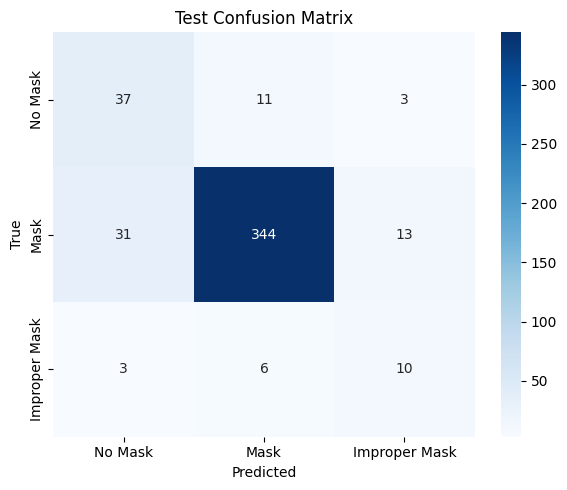

In [10]:
#final training and test evaluation
final_model, _ = train_mlp(hog_train, all_labels, hog_test, test_labels, hog_train.shape[1], best_params['hidden_dim'], best_params['lr'], best_params['dropout'])

#saving final model and weights
model_save_path = model_save_dir / "mlp_hog_weights_dict.pth"
torch.save({k: v.cpu() if isinstance(v, torch.Tensor) else v for k, v in final_model.items()}, model_save_path)

X_test_tensor = torch.tensor(hog_test, dtype=torch.float32).to(device)
with torch.no_grad():
    test_preds = forward_mlp(X_test_tensor, {**final_model, 'train': False}).argmax(1).cpu().numpy()


print("Test Accuracy:", accuracy_score(test_labels, test_preds))
print(classification_report(test_labels, test_preds, target_names=['No Mask', 'Mask', 'Improper Mask']))

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mask', 'Mask', 'Improper Mask'], yticklabels=['No Mask', 'Mask', 'Improper Mask'])
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()
